In [1]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point

In [2]:
tx25_shapefile = gpd.read_file("/Users/codyschank/Dropbox/TX-25/geography/TX25.shp", encoding = 'utf-8')
#project to geographic coordinates to match openaddresses
tx25_shapefile = tx25_shapefile.to_crs({'init': 'epsg:4326'})
tx25_shapefile.columns = map(str.lower, tx25_shapefile.columns)

In [3]:
tx25_shapefile.head()

,statefp,cd115fp,affgeoid,geoid,lsad,cdsessn,aland,awater,geometry
0,48,25,5001500US4825,4825,C2,115,19742494282,316174716,"POLYGON ((-98.56964499999999 31.203269, -98.56..."


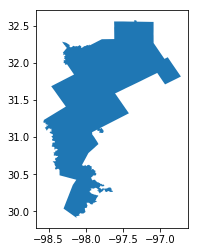

In [4]:
tx25_shapefile.plot()

In [5]:
# Define a database name (we're using a dataset on births, so we'll call it birth_db)
# Set your postgres username
dbname = 'map_the_vote'
username = 'codyschank' # change this to your username

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

postgres://codyschank@localhost/map_the_vote
True


In [6]:
# I don't know why this is necessary, but it is 
tx25_shapefile['geom'] = tx25_shapefile['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))
tx25_shapefile.drop('geometry', 1, inplace=True)

In [7]:
table_name = "tx25"
#had to run this from command line first: psql mydatabasename -c "CREATE EXTENSION postgis";
tx25_shapefile.to_sql(table_name, engine, if_exists='replace', index=False, 
                                dtype={'geom': Geometry('POLYGON', srid= 4326)})

In [8]:
con = None
con = psycopg2.connect(database = dbname, user = username)

# query:
sql_query = """
SELECT * FROM tx25;
"""
tx25_from_sql = pd.read_sql_query(sql_query,con)
tx25_from_sql.head()


,statefp,cd115fp,affgeoid,geoid,lsad,cdsessn,aland,awater,geom
0,48,25,5001500US4825,4825,C2,115,19742494282,316174716,0103000020E6100000010000004A0700001D554D1075A4...


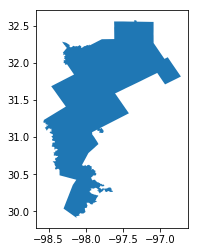

In [9]:
tx25_from_sql_gd = gpd.GeoDataFrame.from_postgis(sql_query, con, geom_col='geom')
tx25_from_sql_gd.plot()
plt.show()